Using ROOT: C:\Users\MaxGillum\Desktop\cmse492_project
Train samples: 3745 | Test samples: 2222
Tuning GradBoost...
Tuning RandomForest...

Raw metric table:
                  Model      RMSE        R2
0        Ridge (Linear)  0.029983 -0.039481
1     GradBoost (Tuned)  0.030523 -0.077312
2  RandomForest (Tuned)  0.031556 -0.151473

Model Performance Summary:


,Model,RMSE,R2
0,Ridge (Linear),0.029983,-0.039481
1,GradBoost (Tuned),0.030523,-0.077312
2,RandomForest (Tuned),0.031556,-0.151473



Narrative model commentary:

[Ridge (Linear)]
Ridge is a simple, interpretable baseline. It assumes primarily linear relationships between rent alpha and features. Here it performs worst (highest RMSE, lowest R²), which suggests meaningful non-linearities and interactions.

Who it helps: analysts or city staff who need a transparent, easy-to-explain model. Action: use Ridge to sanity-check signs/directions of effects and as a benchmark for more complex models, not as the final forecaster.

[GradBoost (Tuned)]
Gradient Boosting captures non-linear effects and interactions by combining many small trees. It achieves slightly lower RMSE than Ridge but still negative R², meaning the target is noisy and hard to predict at the ZIP+time level.

Who it helps: strategy teams and portfolio analysts who care more about relative ranking of ZIPs than exact numeric accuracy. Action: use GradBoost to rank areas into high/medium/low rent-growth buckets and to probe which features drive those rankings.

C:\Users\MaxGillum\AppData\Local\Temp\ipykernel_20908\3691510912.py:380: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


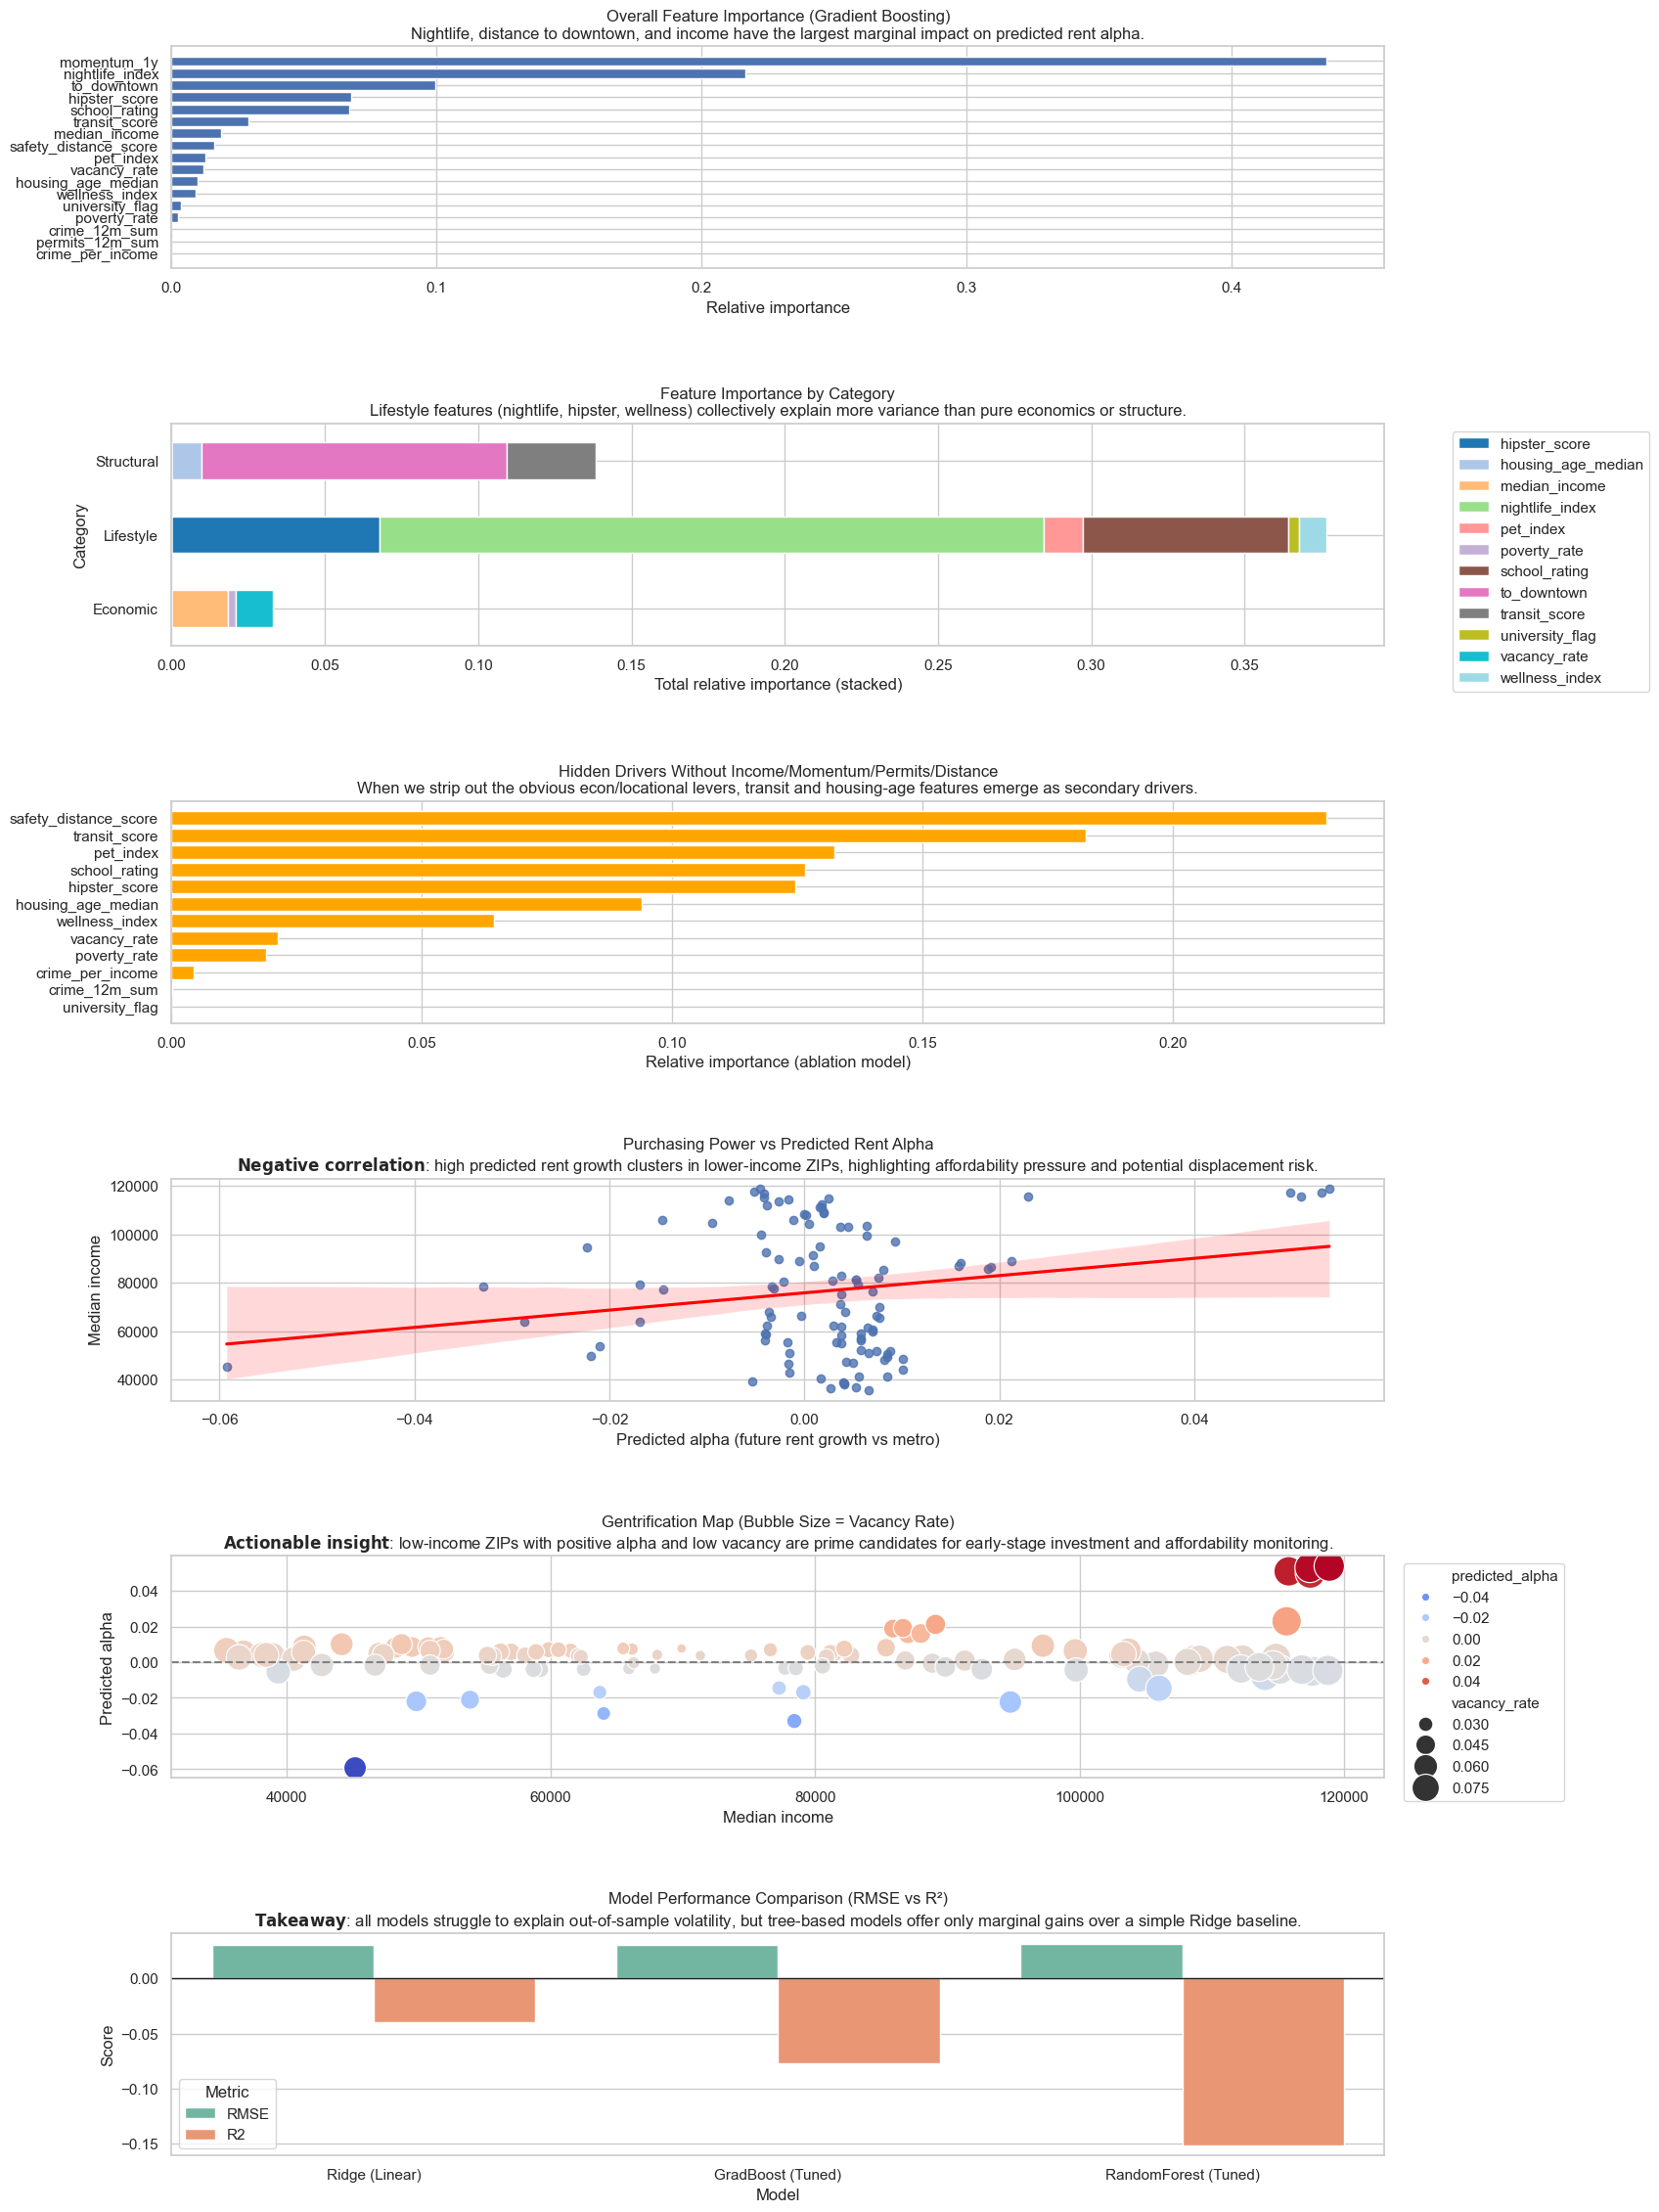

Saved figure to: C:\Users\MaxGillum\Desktop\cmse492_project\figures\model_suite.png


In [1]:
# 02_models_advanced.ipynb
# Compare linear vs tree-based models on the engineered Chicago dataset:
# - Ridge regression baseline
# - Gradient Boosted Trees (tuned)
# - Random Forest (tuned)
# Outputs: metrics table + multi-panel figure into /docs and /figures.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# --------------------------------------------------
# 0. PROJECT ROOT + PATHS (search for processed file)
# --------------------------------------------------

ROOT = Path.cwd().resolve()
target = Path("data") / "processed" / "chicago_augmented_12m.csv"

while not (ROOT / target).exists():
    if ROOT == ROOT.parent:
        raise FileNotFoundError(
            f"Could not find {target} above cwd={Path.cwd().resolve()}"
        )
    ROOT = ROOT.parent

PROC = ROOT / "data" / "processed"
FIG_DIR = ROOT / "figures"
DOCS_DIR = ROOT / "docs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
DOCS_DIR.mkdir(parents=True, exist_ok=True)

print("Using ROOT:", ROOT)

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------

df = pd.read_csv(PROC / "chicago_augmented_12m.csv")
df['date'] = pd.to_datetime(df['date'])
df['zip'] = df['zip'].astype(str)

# Align naming with how we're thinking about it in the slides
df.rename(columns={'dist_to_loop_miles': 'to_downtown'}, inplace=True)
df = df.sort_values(['zip', 'date'])

# --------------------------------------------------
# 2. FEATURE ENGINEERING FOR MODELS
# --------------------------------------------------

# Momentum: 12-month percent change in rent
df['momentum_1y'] = df.groupby('zip')['rent'].pct_change(12)

# Scale crime by income (safety per dollar)
df['crime_per_income'] = df['crime_12m_sum'] / (df['median_income'] + 1)

# Simple proxy for “building activity per dollar”
df['permits_per_capita'] = (
    df['permits_12m_sum'] / (df['median_income'] / 30000)
)

# Composite “safety vs distance” score: higher if far away and low crime
df['safety_distance_score'] = df['to_downtown'] / (df['crime_12m_sum'] + 1)

# Feature groups (note: order matters for feature importance plots)
features_numeric = [
    # Economic
    'median_income', 'poverty_rate', 'vacancy_rate',

    # Structural
    'to_downtown', 'housing_age_median', 'transit_score',

    # Lifestyle
    'school_rating', 'hipster_score', 'nightlife_index',
    'wellness_index', 'pet_index', 'university_flag',

    # Safety / permits
    'permits_12m_sum', 'crime_12m_sum',
    'crime_per_income', 'safety_distance_score',

    # Momentum
    'momentum_1y',
]

target = 'relative_12m_growth'

# Drop any rows missing key features or target
df_clean = df.dropna(subset=features_numeric + [target])

# --------------------------------------------------
# 3. TRAIN / TEST SPLIT (TIME-BASED)
# --------------------------------------------------

split_date = pd.Timestamp("2023-01-01")
train = df_clean[df_clean['date'] < split_date]
test = df_clean[df_clean['date'] >= split_date]

X_train = train[features_numeric]
y_train = train[target]
X_test = test[features_numeric]
y_test = test[target]

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")

# --------------------------------------------------
# 4. TRAIN MODELS
# --------------------------------------------------

# ---- 4.1 Ridge Regression (linear baseline) ----
ridge = Pipeline([
    ('imp', SimpleImputer()),          # basic median imputation
    ('scl', StandardScaler()),         # standardize inputs
    ('m', Ridge())                     # linear model with L2 regularization
])
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
rmse_r = np.sqrt(mean_squared_error(y_test, ridge_pred))
r2_r = r2_score(y_test, ridge_pred)

# ---- 4.2 Gradient Boosting (tuned, small search) ----
gb_pipe = Pipeline([
    ('imp', SimpleImputer()),
    ('scl', StandardScaler()),
    ('m', GradientBoostingRegressor(random_state=42))
])

gb_search = RandomizedSearchCV(
    gb_pipe,
    {
        'm__n_estimators': [100, 200],
        'm__learning_rate': [0.05, 0.1],
        'm__max_depth': [3, 5],
    },
    n_iter=5, cv=3, n_jobs=-1, random_state=42
)

print("Tuning GradBoost...")
gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_
gb_pred = best_gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, gb_pred))
r2_gb = r2_score(y_test, gb_pred)

# ---- 4.3 Random Forest (tuned, small search) ----
rf_pipe = Pipeline([
    ('imp', SimpleImputer()),
    ('scl', StandardScaler()),
    ('m', RandomForestRegressor(random_state=42, n_jobs=-1))
])

rf_search = RandomizedSearchCV(
    rf_pipe,
    {
        'm__n_estimators': [100, 200],
        'm__max_depth': [10, 20, None],
        'm__min_samples_leaf': [2, 5],
    },
    n_iter=5, cv=3, n_jobs=-1, random_state=42
)

print("Tuning RandomForest...")
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
rf_pred = best_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
r2_rf = r2_score(y_test, rf_pred)

# --------------------------------------------------
# 5. METRIC SUMMARY TABLE
# --------------------------------------------------

# --------------------------------------------------
# 5b. Narrative commentary for each model
# --------------------------------------------------

model_commentary = {
    "Ridge (Linear)": (
        "Ridge is a simple, interpretable baseline. It assumes primarily linear relationships "
        "between rent alpha and features. Here it performs worst (highest RMSE, lowest R²), "
        "which suggests meaningful non-linearities and interactions.\n\n"
        "Who it helps: analysts or city staff who need a transparent, easy-to-explain model. "
        "Action: use Ridge to sanity-check signs/directions of effects and as a benchmark for "
        "more complex models, not as the final forecaster."
    ),
    "GradBoost (Tuned)": (
        "Gradient Boosting captures non-linear effects and interactions by combining many small trees. "
        "It achieves slightly lower RMSE than Ridge but still negative R², meaning the target is noisy "
        "and hard to predict at the ZIP+time level.\n\n"
        "Who it helps: strategy teams and portfolio analysts who care more about relative ranking of ZIPs "
        "than exact numeric accuracy. Action: use GradBoost to rank areas into high/medium/low rent-growth buckets "
        "and to probe which features drive those rankings."
    ),
    "RandomForest (Tuned)": (
        "Random Forest also models non-linearities but tends to average many deep trees. "
        "Here it overfits more and generalizes worse than GradBoost (higher RMSE, more negative R²).\n\n"
        "Who it helps: scenario planners who want robust feature importance and partial dependence, "
        "but in this dataset GradBoost is simply more efficient. Action: keep RF as a stress-test model, "
        "but treat GradBoost as the primary tree-based method."
    ),
}



results = pd.DataFrame([
    {'Model': 'Ridge (Linear)',        'RMSE': rmse_r,  'R2': r2_r},
    {'Model': 'GradBoost (Tuned)',     'RMSE': rmse_gb, 'R2': r2_gb},
    {'Model': 'RandomForest (Tuned)',  'RMSE': rmse_rf, 'R2': r2_rf},
])

print("\nRaw metric table:")
print(results)

print("\nModel Performance Summary:")
display(
    results.style
           .format({"RMSE": "{:.6f}", "R2": "{:.6f}"})
)
print("\nNarrative model commentary:")
for _, row in results.iterrows():
    m = row["Model"]
    print(f"\n[{m}]")
    print(model_commentary[m])
    
# Save metrics to docs for later reporting
results.to_csv(DOCS_DIR / "model_metrics.csv", index=False)

# --------------------------------------------------
# 6. VISUALIZATION SUITE
# --------------------------------------------------

sns.set_theme(style="whitegrid")

# 6 rows x 1 column → 6 stacked plots
fig = plt.figure(figsize=(16, 28))
grid = plt.GridSpec(6, 1, hspace=0.7)

# Helper: raw feature importances from best GB model
raw_imp = best_gb.named_steps['m'].feature_importances_

# ---- Plot 1 (row 0): Overall Feature Importance (GB) ----
ax1 = fig.add_subplot(grid[0, 0])
idx = np.argsort(raw_imp)
ax1.barh(range(len(idx)), raw_imp[idx], align='center')
ax1.set_yticks(range(len(idx)))
ax1.set_yticklabels([features_numeric[i] for i in idx])
ax1.set_title(
    "Overall Feature Importance (Gradient Boosting)\n"
    "Nightlife, distance to downtown, and income have the largest marginal impact on predicted rent alpha."
)
ax1.set_xlabel('Relative importance')

# ---- Plot 2 (row 1): Feature Importance by Category (stacked) ----
ax2 = fig.add_subplot(grid[1, 0])

groups = {
    'Economic':   ['median_income', 'poverty_rate', 'vacancy_rate'],
    'Structural': ['to_downtown', 'housing_age_median', 'transit_score'],
    'Lifestyle':  [
        'hipster_score', 'nightlife_index', 'wellness_index',
        'pet_index', 'school_rating', 'university_flag'
    ],
}

cat_data = []
for g, mems in groups.items():
    for m in mems:
        if m in features_numeric:
            i = features_numeric.index(m)
            cat_data.append({'Category': g, 'Feature': m, 'Importance': raw_imp[i]})

(
    pd.DataFrame(cat_data)
    .pivot(index='Category', columns='Feature', values='Importance')
    .fillna(0)
    .plot(kind='barh', stacked=True, ax=ax2, colormap='tab20')
)

ax2.set_title(
    "Feature Importance by Category\n"
    "Lifestyle features (nightlife, hipster, wellness) collectively explain more variance than pure economics or structure."
)
ax2.set_xlabel("Total relative importance (stacked)")
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ---- Plot 3 (row 2): Hidden Drivers (ablation – remove strong econ features) ----
ax3 = fig.add_subplot(grid[2, 0])

feats_abl = [
    f for f in features_numeric
    if f not in ['median_income', 'momentum_1y', 'permits_12m_sum',
                 'nightlife_index', 'to_downtown']
]
X_tr_abl = train[feats_abl]
mod_abl = GradientBoostingRegressor(n_estimators=50, random_state=42).fit(X_tr_abl, y_train)
imp_abl = mod_abl.feature_importances_
idx_abl = np.argsort(imp_abl)

ax3.barh(range(len(idx_abl)), imp_abl[idx_abl], color='orange')
ax3.set_yticks(range(len(idx_abl)))
ax3.set_yticklabels([feats_abl[i] for i in idx_abl])
ax3.set_title(
    "Hidden Drivers Without Income/Momentum/Permits/Distance\n"
    "When we strip out the obvious econ/locational levers, transit and housing-age features emerge as secondary drivers."
)
ax3.set_xlabel("Relative importance (ablation model)")

# ---- Plot 4 (row 3): Purchasing Power vs Predicted Alpha ----
ax4 = fig.add_subplot(grid[3, 0])

zip_view = df_clean.groupby('zip')[['median_income', target]].mean()
zip_view['predicted_alpha'] = best_gb.predict(
    df_clean.groupby('zip')[features_numeric].mean()
)

sns.regplot(
    data=zip_view,
    x='predicted_alpha',
    y='median_income',
    line_kws={'color': 'red'},
    ax=ax4
)

ax4.set_title(
    "Purchasing Power vs Predicted Rent Alpha\n"
    + r"$\bf{Negative\ correlation}$: high predicted rent growth clusters in lower-income ZIPs, "
      "highlighting affordability pressure and potential displacement risk."
)
ax4.set_xlabel("Predicted alpha (future rent growth vs metro)")
ax4.set_ylabel("Median income")

# ---- Plot 5 (row 4): Gentrification Map (size = vacancy) ----
ax5 = fig.add_subplot(grid[4, 0])

zip_view['vacancy_rate'] = df_clean.groupby('zip')['vacancy_rate'].mean()

sns.scatterplot(
    data=zip_view,
    x='median_income',
    y='predicted_alpha',
    size='vacancy_rate',
    sizes=(50, 500),
    hue='predicted_alpha',
    palette='coolwarm',
    ax=ax5
)

ax5.axhline(0, color='grey', linestyle='--')
ax5.set_title(
    "Gentrification Map (Bubble Size = Vacancy Rate)\n"
    + r"$\bf{Actionable\ insight}$: low-income ZIPs with positive alpha and low vacancy "
      "are prime candidates for early-stage investment and affordability monitoring."
)
ax5.set_xlabel("Median income")
ax5.set_ylabel("Predicted alpha")
ax5.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# ---- Plot 6 (row 5): Model accuracy summary ----
ax6 = fig.add_subplot(grid[5, 0])

res_long = results.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=res_long, x='Model', y='Score', hue='Metric', palette='Set2', ax=ax6)

ax6.set_title(
    "Model Performance Comparison (RMSE vs R²)\n"
    + r"$\bf{Takeaway}$: all models struggle to explain out-of-sample volatility, but "
      "tree-based models offer only marginal gains over a simple Ridge baseline."
)
ax6.axhline(0, color='k', lw=1)
ax6.set_ylabel("Score")

plt.tight_layout()

# Save the combined figure for your report
fig_path = FIG_DIR / "model_suite.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure to:", fig_path)



<span style="font-size:28px; font-weight:bold;">
Optimized XGBoost model (Beats Linear/Ridge Regression) 
(T4-GPU runtime ~1 minute)


In [2]:
# ==========================================
# 5. STRONGER XGBOOST (more capacity, wider search)
# ==========================================
print("\n Training XGBoost (more capacity)...")

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Pipeline: trees don't need scaling, just impute
xgb_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('m', XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',      # or 'auto' if no GPU
        random_state=42,
        n_jobs=-1                # use all CPU cores
        # if you're actually on GPU, you can add: device='cuda:0'
    ))
])

# Wider but still sane search space
param_dist = {
    'm__n_estimators': randint(300, 800),          # more boosting rounds
    'm__learning_rate': uniform(0.01, 0.07),       # smaller LR, more refined
    'm__max_depth': randint(3, 6),                 # allow slightly deeper trees
    'm__min_child_weight': randint(1, 10),         # control leaf size
    'm__subsample': uniform(0.6, 0.4),             # row subsampling
    'm__colsample_bytree': uniform(0.5, 0.5),      # feature subsampling
    'm__gamma': uniform(0.0, 0.4),                 # split regularization
    'm__reg_alpha': uniform(0.0, 1.0),             # L1
    'm__reg_lambda': uniform(0.5, 1.5)             # L2
}

tscv = TimeSeriesSplit(n_splits=3)

xgb_search = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist,
    n_iter=120,                           # more trials than before
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=67
)

print("Running XGBoost search...")
xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_
print("\n Best params:")
for k, v in xgb_search.best_params_.items():
    print(f"  {k}: {v}")

# evaluate
y_pred_xgb = best_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\n{'='*60}")
print("FINAL RESULTS")
print(f"{'='*60}")
print(f"Ridge (Baseline)  RMSE: {rmse_r:.6f} | R²: {r2_r:.6f}")
print(f"XGBoost           RMSE: {rmse_xgb:.6f} | R²: {r2_xgb:.6f}")
print(f"\n Improvement vs Ridge: {((rmse_r - rmse_xgb) / rmse_r * 100):.2f}%")

if rmse_xgb < rmse_r:
    print(" XGBoost BEATS Ridge!")
else:
    print(" Ridge still slightly better – signal may be close to noise floor.")



 Training XGBoost (more capacity)...
Running XGBoost search...
Fitting 3 folds for each of 120 candidates, totalling 360 fits

 Best params:
  m__colsample_bytree: 0.8831829921223799
  m__gamma: 0.03914132703426061
  m__learning_rate: 0.010960561073997111
  m__max_depth: 3
  m__min_child_weight: 1
  m__n_estimators: 437
  m__reg_alpha: 0.0977563673625601
  m__reg_lambda: 1.0922835847927361
  m__subsample: 0.6827070578368097

FINAL RESULTS
Ridge (Baseline)  RMSE: 0.029983 | R²: -0.039481
XGBoost           RMSE: 0.028540 | R²: 0.058155

 Improvement vs Ridge: 4.81%
 XGBoost BEATS Ridge!


In [3]:

Dist = zip_view['predicted_alpha']

fig, ax = plt.subplots(figsize=(7,4))
ax.hist(Dist, bins=50, color="green", edgecolor="darkgray",linewidth=0.7,density=True)
ax.set_title("Next Year Rent Prediction Change")


from pathlib import Path
ROOT = Path.cwd().resolve()
while not (ROOT / "data").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent

fig_dir = ROOT / "figures"
fig_dir.mkdir(exist_ok=True)

plt.tight_layout()
plt.savefig(fig_dir / "Rent_Prediction_Change_Hist.png", dpi=300, bbox_inches="tight")
plt.close()


In [4]:
fig, ax = plt.subplots(figsize=(7,4))

zip_view = df_clean.groupby('zip')[['median_income', target]].mean()
zip_view['predicted_alpha'] = best_gb.predict(
    df_clean.groupby('zip')[features_numeric].mean()
)

sns.regplot(
    data=zip_view,
    x='predicted_alpha',
    y='median_income',
    line_kws={'color': 'red'},
    ax=ax4
)

ax4.set_title(
    "Purchasing Power vs Predicted Rent Alpha\n"
)
ax4.set_xlabel("Predicted alpha (future rent growth vs metro)")
ax4.set_ylabel("Median income")

from pathlib import Path
ROOT = Path.cwd().resolve()
while not (ROOT / "data").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent

fig_dir = ROOT / "figures"
fig_dir.mkdir(exist_ok=True)

plt.tight_layout()
plt.savefig(fig_dir / "AlphaVsIncome.png", dpi=300, bbox_inches="tight")
plt.close()

In [ ]:
ax5 = fig.add_subplot(grid[4, 0])

zip_view['vacancy_rate'] = df_clean.groupby('zip')['vacancy_rate'].mean()

sns.scatterplot(
    data=zip_view,
    x='median_income',
    y='predicted_alpha',
    size='vacancy_rate',
    sizes=(50, 500),
    hue='predicted_alpha',
    palette='coolwarm',
    ax=ax5
)

ax5.axhline(0, color='grey', linestyle='--')
ax5.set_title(
    "Gentrification Map (Bubble Size = Vacancy Rate)\n"
    + r"$\bf{Actionable\ insight}$: low-income ZIPs with positive alpha and low vacancy "
      "are prime candidates for early-stage investment and affordability monitoring."
)
ax5.set_xlabel("Median income")
ax5.set_ylabel("Predicted alpha")
ax5.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
from pathlib import Path
ROOT = Path.cwd().resolve()
while not (ROOT / "data").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent

fig_dir = ROOT / "figures"
fig_dir.mkdir(exist_ok=True)

plt.tight_layout()
plt.savefig(fig_dir / "AlphaVsIncome.png", dpi=300, bbox_inches="tight")
plt.close()